# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Leticia Martín Cabrera</font>

E-mail: <font color="blue">leticia.martin03@estudiant.upf.edu</font>

Date: <font color="blue">02/11/2021</font>

In [2]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [3]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [4]:
def jaccard_similarity(x,y):
    set1 = set(x)
    set2 = set(y)
    union = set1.union(set2)
    intersection = set1.intersection(set2)
    if len(union) == 0:
        return 0.0
    else:
        return len(intersection)/len(union)
    


In [5]:
array1 = [0,0,0]
array2 = [0,0,0]
array3 = [0,2,3]
array4 = []
array5 = []

print("First test:", jaccard_similarity(array1,array4))
print("Second test:",jaccard_similarity(array2,array3))
print("Third test:",jaccard_similarity(array1,array2))
print("Forth test:",jaccard_similarity(array4,array5))


First test: 0.0
Second test: 0.3333333333333333
Third test: 1.0
Forth test: 0.0


In [6]:
import unicodedata
def clean(text):
    text = text.lower()
    text =  re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    for c in text:
        if not c.isalnum() and c != " ":
            text = text.replace(c, "")
    result = str(unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore'))[2:-1]
    return result


In [7]:
text = "RT @Inigo_1987: I am Íñigo Montoya! https://t.co/aaa"

print(clean(text))

rt inigo1987 i am inigo montoya 


# 2. Implement an n-gram extractor

In [8]:
MIN_TOKEN_LENGTH = 2

def ngrams(text, size):
    tokens = clean(text).split()
    for word in tokens:
        if len(word) < MIN_TOKEN_LENGTH:
            tokens.remove(word)
    ngrams = []
    for i in range(len(tokens)-size+1):
        new = tokens[i:i+size]
        ngrams.append(" ".join(new))
    return ngrams


In [9]:
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['rt diariara', 'diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [10]:
# Leave this code as-is

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

Text(0, 0.5, 'Time to check the messages')

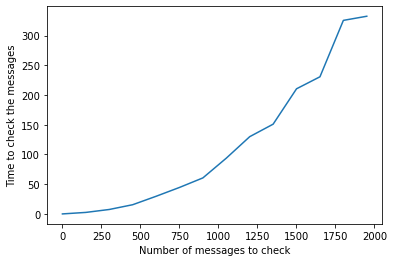

In [11]:
num_messages = np.arange(1,2001,150)
time = []
for i in num_messages:
    time.append(time_brute_force_similarities(messages, i, 3))
plt.plot(num_messages, time)
plt.xlabel("Number of messages to check")
plt.ylabel("Time to check the messages")

We can see that the plot follows an exponential distribution, as the number of messages to check increases, the time it takes to check them increases.

In [12]:
#We assume that the time to do all compararisons (10000 messagesx10000messages) is proportional to the one of doing 2000x2000 comparisons
total_time = (10000**2)*time[-1]/2000**2  #time in seconds
minutes = total_time/60 
hours = total_time/3600
print("Running the brute force similarity computations would take: \n",total_time, "seconds\n",minutes, "minutes\n",hours,"hours")

Running the brute force similarity computations would take: 
 8311.590175000003 seconds
 138.52650291666671 minutes
 2.308775048611112 hours


# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [13]:
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0


for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index.keys():
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 70408 distinct ngrams in the 10000 documents


In [14]:
print("The index of 'tancar escoles fins' ngram in the dictionary is: ",ngram_to_index["tancat escoles fins"])
print("The index",ngram_to_index["tancat escoles fins"] ,"corresponds to: " ,index_to_ngram[ngram_to_index["tancat escoles fins"]])

The index of 'tancar escoles fins' ngram in the dictionary is:  991
The index 991 corresponds to:  tancat escoles fins


## 4.2 Create table ngrams x documents

In [15]:
# Leave this code as-is

# Create matrix filled with boolean False
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print number of rows and columns
print("Rows: %d (distinct shingles)" % len(M_ngram_doc))
print("Columns: %d (distinct documents)" % len(M_ngram_doc[0]))

Rows: 70408 (distinct shingles)
Columns: 10000 (distinct documents)


In [16]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        index = ngram_to_index[ngram]
        M_ngram_doc[index][docid] = True

In [17]:
non_zeros_9602 = []
for i in range(len(M_ngram_doc[:,9602])):
    new = "" 
    if  M_ngram_doc[i,9602]:
        new = str(i) + " ("+ str(index_to_ngram[i]) +")"
        non_zeros_9602.append(new)

print("Positions of non-zeros in column of docid 9602 of M_ngram_doc")
print("Clean message:\n", clean(messages[9602]) )        
print("Non-zeros in corresponding row: ", non_zeros_9602)


Positions of non-zeros in column of docid 9602 of M_ngram_doc
Clean message:
 rt emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio 
Non-zeros in corresponding row:  ['690 (rt emergenciescat que)', '963 (si us plau)', '1284 (emergenciescat que puc)', '1285 (que puc fer)', '1286 (puc fer que)', '1287 (fer que no)', '2702 (14 de marc)', '41028 (que no faqs)', '41029 (no faqs del)', '41030 (faqs del coronavirus)', '41031 (del coronavirus 14)', '41032 (coronavirus 14 de)', '41033 (de marc si)', '41034 (marc si us)', '41035 (us plau demanem)', '41036 (plau demanem difusio)']


In [18]:
non_zeros_941 = []
for i in range(len(M_ngram_doc[:,941])):
    new = "" 
    if  M_ngram_doc[i,941]:
        new = str(i) + " ("+ str(index_to_ngram[i]) +")"
        non_zeros_941.append(new)

print("Positions of non-zeros in column of docid 941 of M_ngram_doc")
print("Clean message:\n", clean(messages[941]) )        
print("Non-zeros in corresponding row: ", non_zeros_941)

Positions of non-zeros in column of docid 941 of M_ngram_doc
Clean message:
 rt hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general
Non-zeros in corresponding row:  ['1552 (usem de forma)', '1553 (de forma responsable)', '1554 (forma responsable els)', '1555 (responsable els recursos)', '1556 (els recursos sanitaris061)', '1557 (recursos sanitaris061 urgencies)', '1558 (sanitaris061 urgencies per)', '1559 (urgencies per coronavirus)', '1560 (per coronavirus sanitaries012)', '1561 (coronavirus sanitaries012 consultes)', '10786 (rt hospiolot usem)', '10787 (hospiolot usem de)', '10788 (sanitaries012 consultes general)']


# 5. Implement a permutation generator

In [19]:
def random_permutation(k):
    array = np.arange(k)
    random.shuffle(array)
    return array

print(random_permutation(20))

[13 14 19 11  3 18  7  9  5 15  0  6  8 16 12  1 17 10  4  2]


In [20]:
# Leave this code as-is

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["a", "b", "c", "d", "e"]
original_list_2 = ["alpha", "beta", "gamma", "delta", "epsilon"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['d', 'a', 'b', 'e', 'c']
['delta', 'alpha', 'beta', 'epsilon', 'gamma']

Test another permutation
['d', 'a', 'b', 'e', 'c']
['delta', 'alpha', 'beta', 'epsilon', 'gamma']


# 6. Compute the signature of each document

In [21]:
# Leave this code as-is

NUM_PERMUTATIONS = 4

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 9825, 30552, 48929, ...
Permutation 1: 55418, 44416, 45489, ...
Permutation 2: 18350, 30541, 62369, ...
Permutation 3: 38562, 46159, 29021, ...


In [22]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        M_signature_doc[permutation_num,docid] = find_first_one(docid,permutation)

Creating signatures for permutation 1/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/4
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [23]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, docid):
    print("Document #%d" % docid)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 84
j = 6586

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #84
Message       : RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Clean message : rt emergenciescat  es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
Ngrams        : [277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297]
Signature     : [288.0, 285.0, 296.0, 283.0]

Document #6586
Message       : RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…
Clean message : rt emergenciescat  es demana a la ciutadania limitar al maxim i si es pot evitar desplacaments de cap de setmana tot el que sigui ma
Ngrams        : [277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297]
Signature     : [288.0, 285.0, 296.0, 283.0]


# 7. Compare all pairs of signatures

In [24]:
is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                if jaccard_similarity(signature1, signature2) == 1:
                    count_sig_full_matches += 1  #Increase count_sig_full_matches
                    is_possible_duplicate[docid1] = docid2 #Include docid2 in is_possible_duplicate if needed
                elif 0.2 < jaccard_similarity(signature1, signature2) < 1:
                    count_sig_partial_matches += 1  #Increase count_sig_partial_matches
                    is_possible_duplicate[docid1] = docid2   #Include docid2 in is_possible_duplicate if needed
                

        # REPLACE THIS COMMENT WITH YOUR CODE
        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        threshold = 50
        if count_sig_full_matches + count_sig_partial_matches > threshold:
            print("Document", docid1,": ", count_sig_full_matches," Full matches ", count_sig_partial_matches ,"Partial matches")
         

0/10000 documents scanned
Document 16 :  89  Full matches  0 Partial matches
Document 42 :  46  Full matches  6 Partial matches
Document 53 :  57  Full matches  0 Partial matches
Document 84 :  88  Full matches  0 Partial matches
Document 85 :  45  Full matches  6 Partial matches
Document 166 :  56  Full matches  0 Partial matches
Document 167 :  55  Full matches  0 Partial matches
Document 168 :  54  Full matches  0 Partial matches
Document 172 :  53  Full matches  0 Partial matches
Document 174 :  52  Full matches  0 Partial matches
Document 176 :  51  Full matches  0 Partial matches
Document 307 :  87  Full matches  0 Partial matches
Document 328 :  65  Full matches  0 Partial matches
Document 331 :  64  Full matches  0 Partial matches
Document 412 :  63  Full matches  0 Partial matches
Document 425 :  86  Full matches  0 Partial matches
Document 448 :  62  Full matches  0 Partial matches
500/10000 documents scanned
Document 578 :  56  Full matches  0 Partial matches
Document 587 : 

In [25]:
print(messages[5077])

RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK


This message has the most full matches (175) and it has 0 partial matches. It could be because the message asks for diffusion, those that have copied and retweeted it have done so literally.

In [26]:
print(messages[627])

PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa


This message has the most partial matches (66) and it has 0 full matches. It could be because it contains some hastags so these could appear in other tweets.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>